<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_6_2_Instance_Segmentation_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

!pip install opencv-contrib-python
import cv2
from skimage import io

# Instance segmentation:

* Difference among **object detection, semantic segmentation, and instance segmentation**.

see - https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46






# Introduction to Mask RCNN

https://arxiv.org/pdf/1703.06870.pdf


https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

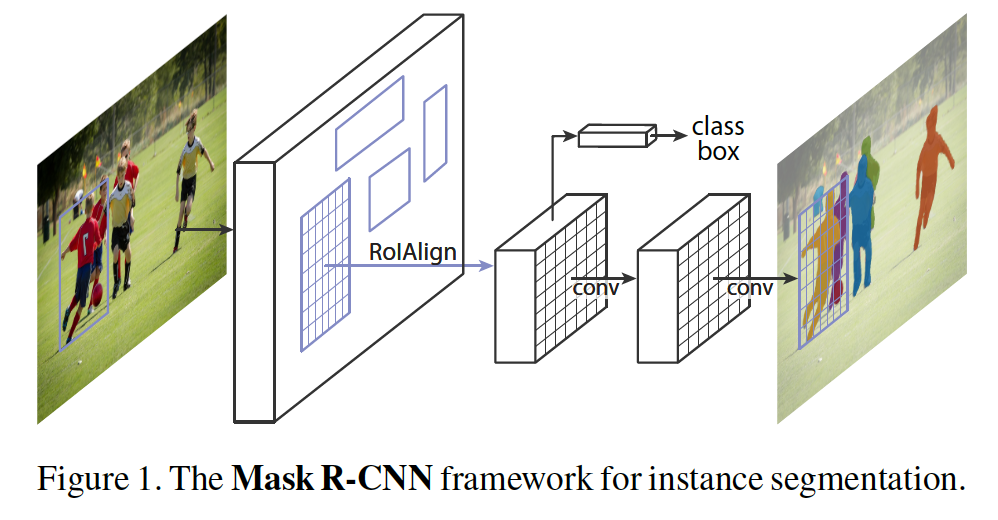

# Read Mask R-CNN model

In [2]:
model = models.detection.maskrcnn_resnet50_fpn(weights=models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval();
model,

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 147MB/s]


(MaskRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): BackboneWithFPN(
     (body): IntermediateLayerGetter(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): FrozenBatchNorm2d(64, eps=0.0)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): FrozenBatchNorm2d(64, eps=0.0)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): FrozenBatchNorm2d(64, eps=0.0)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): FrozenBatchNorm2d(256, eps=0.0)
      

# Code: `get_prediction`

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
print('# COCO Labels (including background):', len(COCO_INSTANCE_CATEGORY_NAMES))


def get_prediction(img, threshold):
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model( [img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    masks =[]; pred_boxes = []; pred_class = []
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
    if pred_t :
        pred_t = pred_t[-1]
        masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
        pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
        masks = masks[:pred_t+1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class



# COCO Labels (including background): 91


# Code: `random_colour_masks`

In [4]:
import random
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask


# `instance_segmentation_api`

In [5]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=2, text_th=3):
    if isinstance(img_path, np.ndarray) :
        img = img_path
    else :
        print('reading from web')
        img = io.imread(img_path)
    if img.shape[2] > 3 :
        img = img[:,:,0:3] # remote more than 3 channels for the image
    masks, boxes, pred_cls = get_prediction(img, threshold)
    print ('Number of instances detected: ', len(masks))
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        box = boxes[i]
        top_left = (int(box[0][0]), int(box[0][1]))
        bottom_right = (int(box[1][0]), int(box[1][1]))

        cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), rect_th)

        cv2.putText(img,pred_cls[i], top_left, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

    return(img)


# Code: Example on web images

In [ ]:
nr = 2
nc = 3 # number of rows and columns of display
fig, ax = plt.subplots(nr, nc)
fig.set_size_inches(40, 20)

# If the following image links do not work any more, replace them with
# new links.
images = ['http://3.bp.blogspot.com/-WtKPPFvgeSE/Tpg9j_35mDI/AAAAAAAAm8g/_j7Oha9_-5k/s1600/DC-778499.JPG',
          'http://1.bp.blogspot.com/-0R2mtabjCRc/Tpg9kMMGb7I/AAAAAAAAm8w/3CDjm4oypAA/s1600/DC1-780177.JPG',
          'http://1.bp.blogspot.com/-yZ7qqLXOmEQ/Tpg9lFxqIII/AAAAAAAAm84/ncNCfN1EUgo/s1600/DC5.-783780.JPG',
          'https://live.staticflickr.com/1843/44763078441_06c9a20331_b.jpg',
          'https://wildtravel.ro/wp-content/uploads/2023/01/za.jpg']

for i in range(len(images)) :
    seg_img = instance_segmentation_api(images[i])
    ax[np.unravel_index(i, (nr, nc))].imshow(seg_img)



reading from web
Number of instances detected:  9
reading from web
Number of instances detected:  6
reading from web
Number of instances detected:  23
reading from web
Number of instances detected:  3
reading from web


# Code: Process Video

Number of instances detected:  19
Number of instances detected:  19
Number of instances detected:  15
Number of instances detected:  13
Number of instances detected:  13
Number of instances detected:  10
Number of instances detected:  13
Number of instances detected:  11
Number of instances detected:  12
Number of instances detected:  12
Number of instances detected:  17
Number of instances detected:  10
Number of instances detected:  18
Number of instances detected:  17
Number of instances detected:  20
Number of instances detected:  16
Number of instances detected:  13
Number of instances detected:  13
Number of instances detected:  15
Number of instances detected:  19


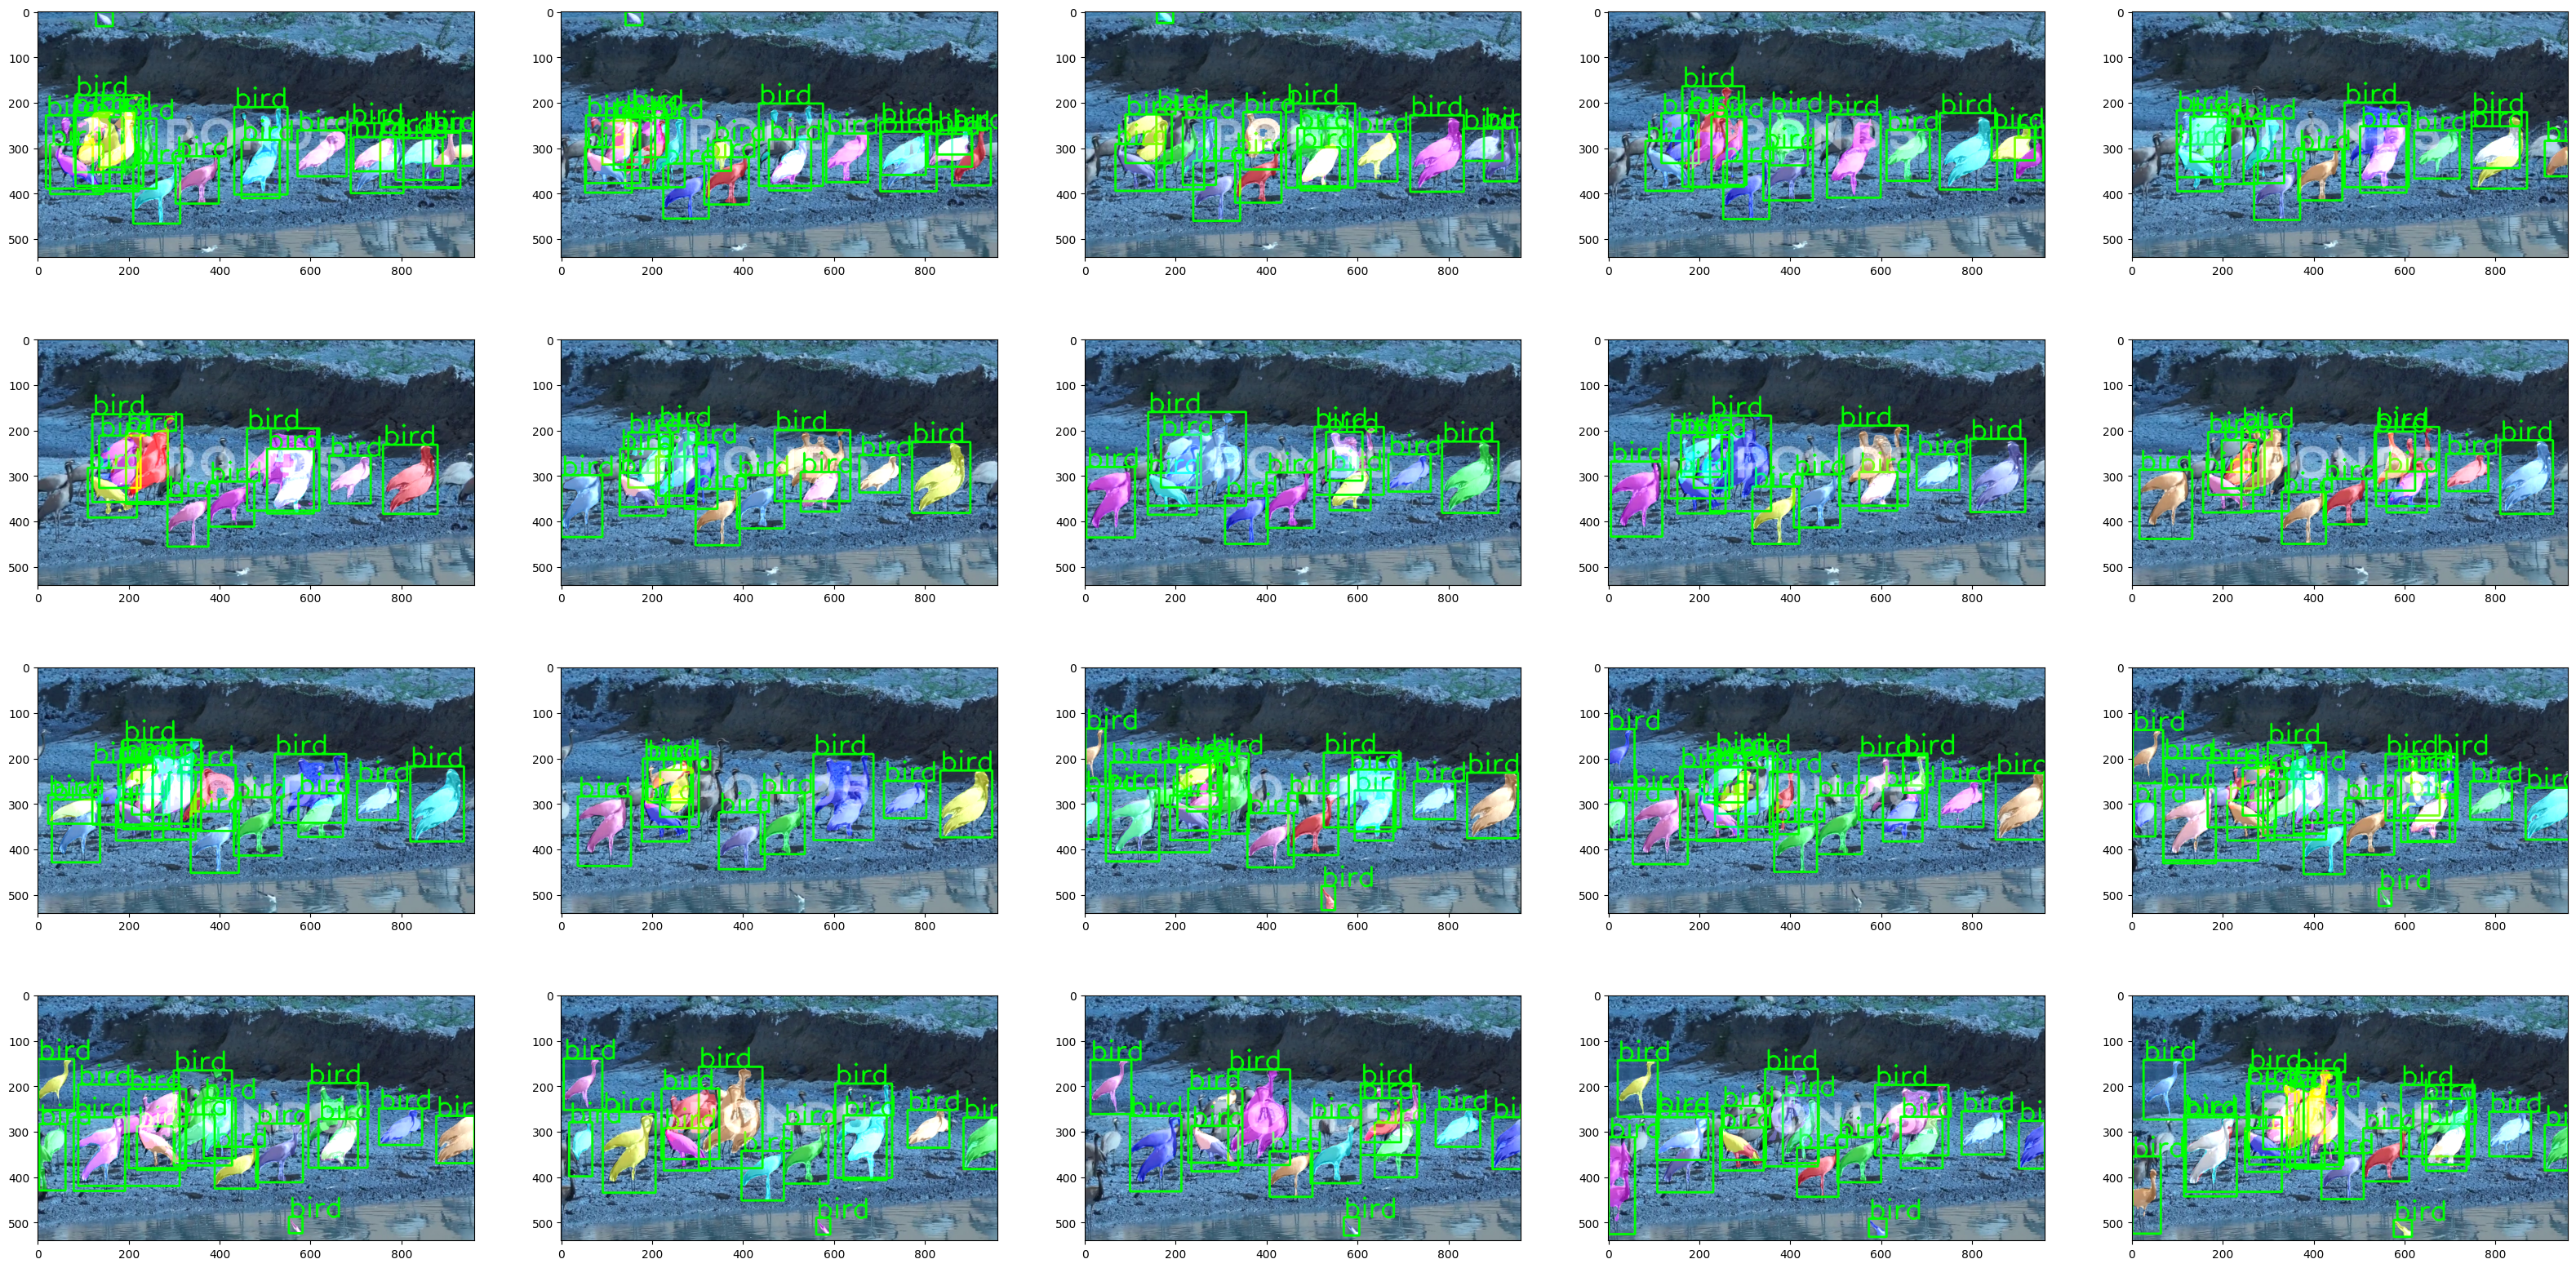

In [7]:
# Replace the following video link with one that works if the following
# does not work anymore.
cap = cv2.VideoCapture('https://videos.pond5.com/demoiselle-crane-koonj-footage-110992583_main_xxl.mp4')
if (cap.isOpened()== False):
    print("Error opening video stream or file")
i = 0
nr = 4
nc = 5 # number of rows and columns of display
fig, ax = plt.subplots(nr, nc)
fig.set_size_inches(40, 20)

while(cap.isOpened() and i < nr*nc):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Display the resulting frame
        seg_img = instance_segmentation_api(frame)
        ax[np.unravel_index(i, (nr, nc))].imshow(seg_img)
        i = i+1

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()